# Multigrid Example

In [1]:
# dependencies
using LFAToolkit
using LinearAlgebra
using Pkg
Pkg.activate("./")
Pkg.instantiate()
using Plots

 Activating environment at `~/Dev/LFAToolkit.jl/examples/jupyter/Project.toml`


In [77]:
# setup
finep = 5
coarsep = 3
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

ctofbasis = TensorH1LagrangeBasis(coarsep, finep, dimension, lagrangequadrature=true)

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# Jacobi smoother
jacobi = Jacobi(finediffusion)

# p-multigrid preconditioner
multigrid = PMultigrid(finediffusion, coarsediffusion, jacobi, [ctofbasis])

p-multigrid preconditioner

max eigenvalue: 2.0204058428824596
min eigenvalue: -5.641706399185673e-16
max high eigenvalue: 1.979591836734694
min high eigenvalue: -3.822331079495898e-16


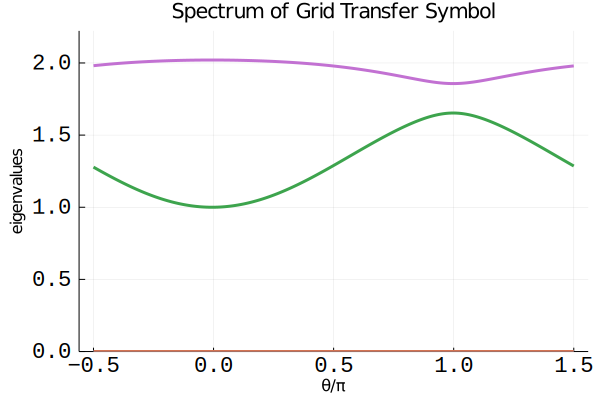

In [78]:
# full operator symbols
numberruns = 250
maxeigenvalue = 0
mineigenvalue = 1
maxeigenvalue_high = 0
mineigenvalue_high = 1
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    smoothingfactor = zeros(numberruns)
    maxeigenvalues = zeros(finep - 1, numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1] % 2π) >  π/512
            A = LFAToolkit.computesymbolspprolongation(multigrid, θ) * LFAToolkit.computesymbolsprestriction(multigrid, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[1:finep-1, i] = [real(val) for val in eigenvalues]
            maxeigenvalue = max(maxeigenvalue, max([real(val) for val in eigvals(A)]...))
            mineigenvalue = min(mineigenvalue, min([real(val) for val in eigvals(A)]...))
            if θ[1] > π/2
                maxeigenvalue_high = max(maxeigenvalue_high, max([real(val) for val in eigvals(A)]...))
                mineigenvalue_high = min(mineigenvalue_high, min([real(val) for val in eigvals(A)]...))
            end
        end
    end

    # plot

    # plot
    println("max eigenvalue: ", maxeigenvalue)
    println("min eigenvalue: ", mineigenvalue)
    println("max high eigenvalue: ", maxeigenvalue_high)
    println("min high eigenvalue: ", mineigenvalue_high)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(xrange,
        maxeigenvalues[1,:],
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        ylabel="eigenvalues",
        ytickfont=font(12, "Courier"),
        linewidth=3,
        legend=:none,
        title="Spectrum of Grid Transfer Symbol"
    )
    for i in 2:finep-1
        plot!(xrange,
            maxeigenvalues[i,:],
            linewidth=3,
        )
    end
    ylims!(0.0, max(maxeigenvalues...)*1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [1.0]
    smoothingfactor = zeros(numberruns)
    ω_min = [0.0, 1.0]

    # compute
    for i in 1:numberruns
        ω = [ω_max*i/numberruns]
        for j in 1:numberruns, k in 1:numberruns
            θ = [
                θ_min + (θ_max - θ_min)*j/numberruns,
                θ_min + (θ_max - θ_min)*k/numberruns
            ]
            if θ[1] > π/2 || θ[2] > π/2
                A = computesymbols(multigrid, ω, v, θ)
                eigenvalues = [abs(val) for val in eigvals(A)]
                smoothingfactor[i] = max(smoothingfactor[i], eigenvalues...)
                if smoothingfactor[i] < ω_min[2]
                    ω_min = [ω[1], smoothingfactor[i]]
                end
            end
        end
    end

    # plot
    xrange = 0:ω_max/(numberruns-1):ω_max
    plot(xrange, smoothingfactor, title="Smoothing Factors")
    ylims!(0.0, max(smoothingfactor...))
end